ncalls
3.3991506
2.7377908
1.9546388
0.7322214
-0.7094770
-2.0574763


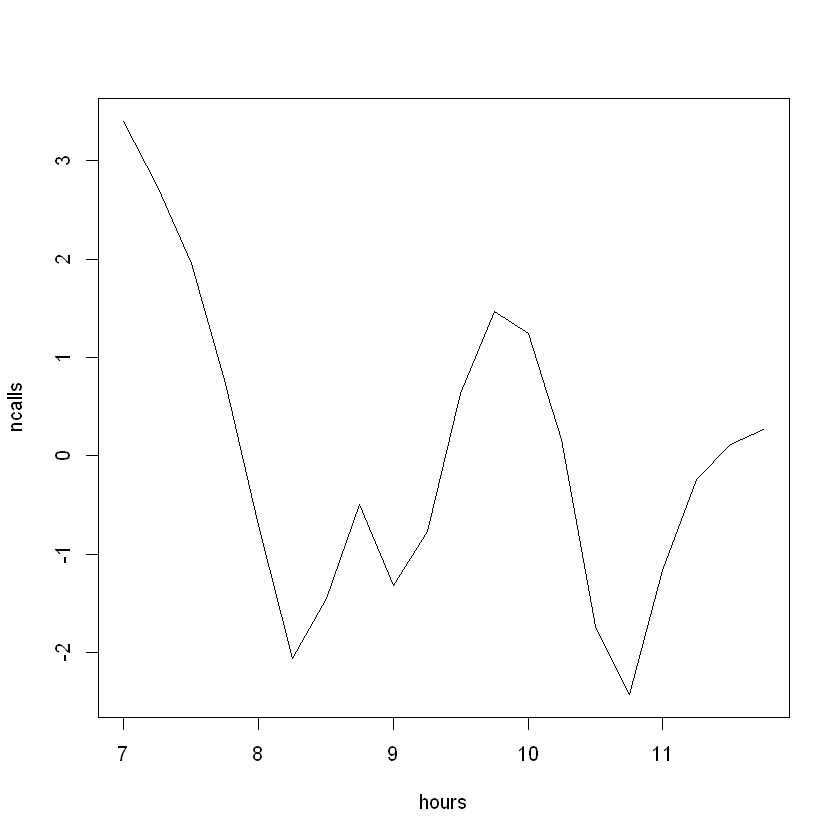

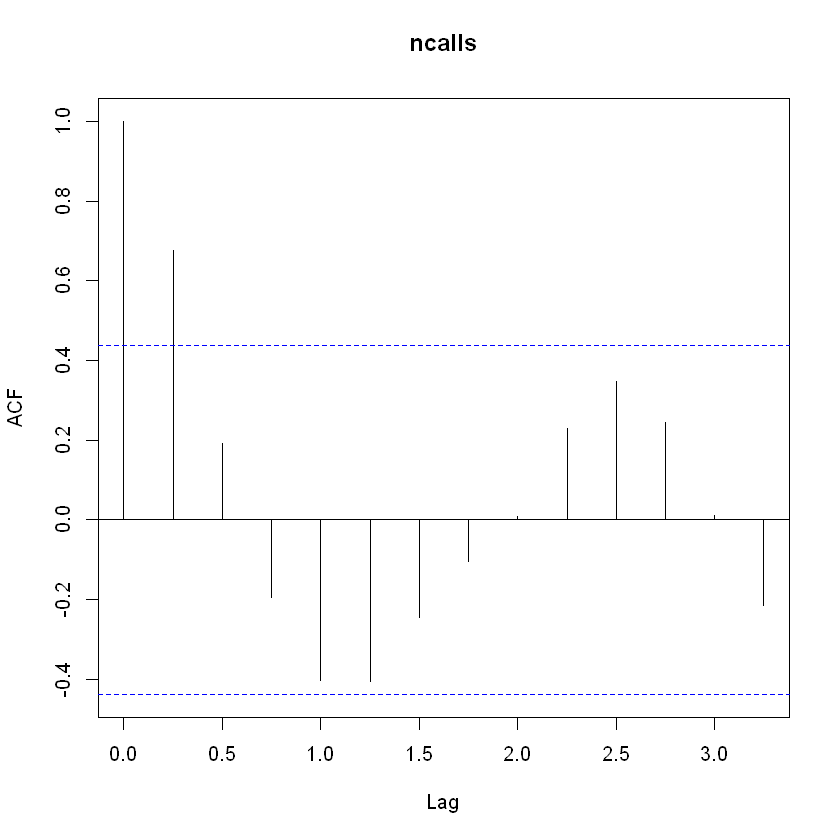

Warning message in kpss.test(calls_series):
"p-value greater than printed p-value"


	KPSS Test for Level Stationarity

data:  calls_series
KPSS Level = 0.26813, Truncation lag parameter = 1, p-value = 0.1


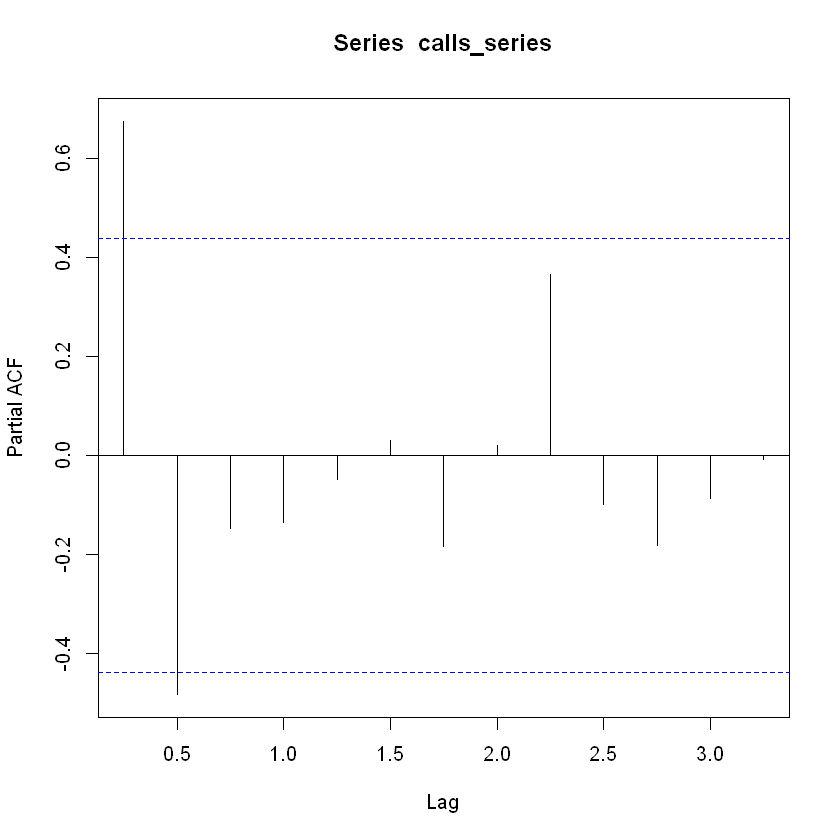

In [2]:
filePath <- "http://www.statslab.cam.ac.uk/~tw389/teaching/SLP18/data/"
fileName <- "calls"
calls_number <- read.table(paste0(filePath, fileName), header=T)
head(calls_number)
calls_series<-ts(data=calls_number,start=c(7,1),frequency=4)
plot(calls_series,xlab="hours")
acf(calls_series) # sample ACF
pacf(calls_series) # sample ACF
library(tseries)
kpss.test(calls_series) # testing for stationarity


There no obvious non-stationality here -- the number of calls do no appear to have a trend or period. The KPSS test does not reject the null hypothesis. So say this is stationary from now on. 

Let's try to fit a model here. The acf suggests using MA of order at most 1. Partial ACF suggests AR of at most 2

We shall used a zero mean model because the mean is close to 0 anyway.

In [8]:
for (p in 0:2) for (q in 0:1){
cat('p = ', p, 'q = ', q, 'AIC = ',
AIC(arima(calls_series, order=c(p,0,q), include.mean=F)), '\n')
}


p =  0 q =  0 AIC =  75.99247 
p =  0 q =  1 AIC =  58.97348 
p =  1 q =  0 AIC =  60.90828 
p =  1 q =  1 AIC =  50.45941 
p =  2 q =  0 AIC =  51.41582 
p =  2 q =  1 AIC =  50.9641 


In [9]:
arima(calls_series, order=c(1,0,1), include.mean=F)


Call:
arima(x = calls_series, order = c(1, 0, 1), include.mean = F)

Coefficients:
         ar1     ma1
      0.6997  0.9510
s.e.  0.1796  0.3287

sigma^2 estimated as 0.4449:  log likelihood = -22.23,  aic = 50.46

Series: calls_series 
ARIMA(1,0,1) with zero mean 

Coefficients:
         ar1     ma1
      0.6997  0.9510
s.e.  0.1796  0.3287

sigma^2 estimated as 0.4944:  log likelihood=-22.23
AIC=50.46   AICc=51.96   BIC=53.45

      Point Forecast      Lo 95    Hi 95
12 Q1   3.291853e-01 -0.9876043 1.645975
12 Q2   2.303417e-01 -2.2952153 2.755899
12 Q3   1.611776e-01 -2.7803367 3.102692
12 Q4   1.127812e-01 -3.0122706 3.237833
13 Q1   7.891669e-02 -3.1321763 3.290010
13 Q2   5.522058e-02 -3.1971705 3.307612
13 Q3   3.863964e-02 -3.2337819 3.311061
13 Q4   2.703741e-02 -3.2551470 3.309222
14 Q1   1.891896e-02 -3.2680351 3.305873
14 Q2   1.323821e-02 -3.2760486 3.302525
14 Q3   9.263208e-03 -3.2811652 3.299692
14 Q4   6.481768e-03 -3.2845054 3.297469
15 Q1   4.535504e-03 -3.2867253 3.295796
15 Q2   3.173640e-03 -3.2882211 3.294568
15 Q3   2.220699e-03 -3.2892396 3.293681
15 Q4   1.553896e-03 -3.2899385 3.293046
16 Q1   1.087311e-03 -3.2904208 3.292595
16 Q2   7.608272e-04 -3.2907550 3.292277
16 Q3   5.323756e-04 -3.2909872 3.292052
16 Q4   3.725205e-04 -3.2911489 3.291894
17 Q1   2.606648e-04 -3.2912617 3.291783
17 Q2   1.823956e-04 -3.2913404 3.291705
17 Q3   1.276282e-04 -3.2913954 3.291651
17 Q4   8.930558

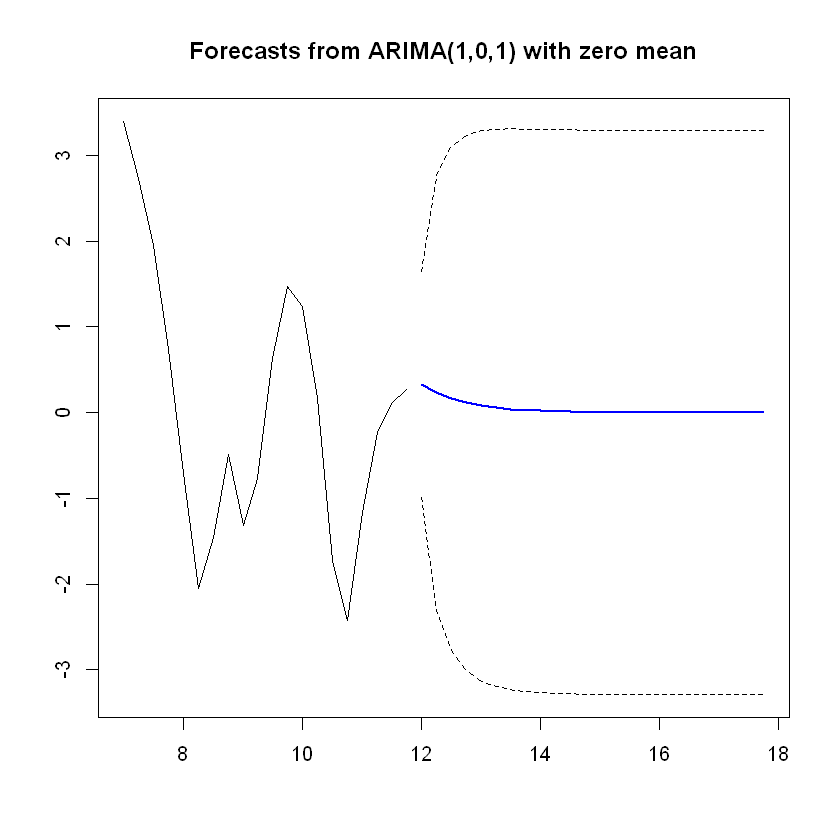

In [15]:
library(forecast)
auto.arima(calls_series, ic='aic', seasonal = FALSE)
calls.arma <- arima(calls_series, order=c(1,0,1), include.mean=F) # fit selected model

fc <- forecast(calls.arma, 24, level=95)
fc
plot(forecast(calls.arma, 24, level=95), shaded=F)


The predictions depend on the past data, since the ACF decays exponentially fast, the predicted values quickly decay to 0, with the confidence band being the variance of the noise.

The predicted variances are the marinal variance.

We can find the predicted variance with this command:

In [17]:
pi <- ARMAtoMA(ar=calls.arma$coef[1], ma=calls.arma$coef[2], lag.max=100)
(sum(pi^2)+1)*calls.arma$sigma2


[1] 2.820315

This confidence is actually too optimistic -- We're assuming that the fitted model is the true model. In actuality, the model selection and parameter estimation adds uncertainty to the forecast values.

We can see this by generating a bunch of length 60 chains, fitting the first 50 then predicting the last 10.

Intuitively, we have chosen the values and models which minimise uncertainty. So naturally the predicted uncertainty should lower.

As one can observe in the graph, the orange line is the loss of coverage due to parameter selection, and the blue is due to model selection.

[1] 3

0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%76%77%78%79%80%81%82%83%84%85%86%87%88%89%90%91%92%93%94%95%96%97%98%99%100%


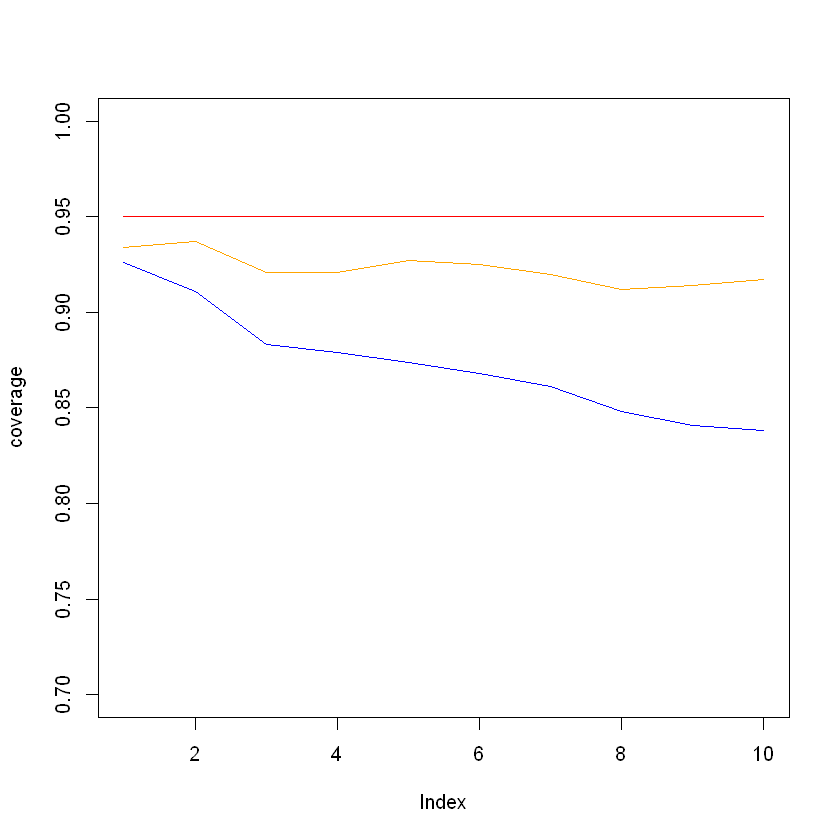

In [19]:
library(rje)
set.seed(2018)
niter <- 1000
cover1 <- cover2 <- matrix(0,niter,10)
3
for (iter in 1:niter){
dat <- arima.sim(list(order=c(1,1,1), ar=0.5, ma=0.5), n=60, sd=1)
x <- dat[1:50]; actual <- dat[51:60]
mod1 <- arima(x, order=c(1,1,1))
fc1 <- forecast(mod1, 10, level=95)
mod2 <- auto.arima(x, ic='aic', seasonal=F)
fc2 <- forecast(mod2, 10, level=95)
cover1[iter,] <- (fc1$lower <= actual) & (fc1$upper >= actual)
cover2[iter,] <- (fc2$lower <= actual) & (fc2$upper >= actual)
printPercentage(iter,niter)
}
plot(colSums(cover1)/niter, type='l', ylim=c(0.7,1), col='orange',
ylab='coverage')
points(colSums(cover2)/niter, type='l', col='blue')
points(rep(0.95,10), type='l', col='red')


We now try to predict some stock data.

Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following object is masked from 'package:rje':

    last

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.

Please see the Warning section of '?getSymbols.yahoo' for details.

This message is shown once per session and may be disabled by setting
options("getSymbols.yahoo.warning"=FALSE).


[1] "SLP"

           SLP.Adjusted
2010-01-04     1.124547
2010-01-05     1.132697
2010-01-06     1.157143
2010-01-07     1.108250
2010-01-08     1.108250
2010-01-11     1.100101

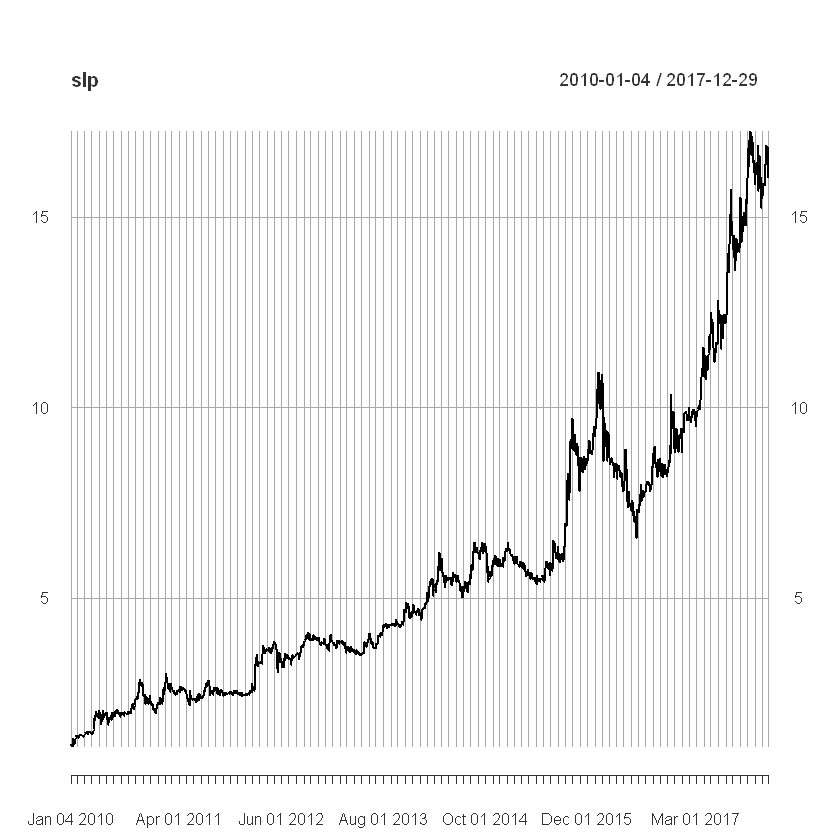

In [20]:
library(quantmod)
getSymbols('SLP', from='2010-01-01', to='2018-01-01')
slp = SLP[,6]
head(slp)
plot(slp)

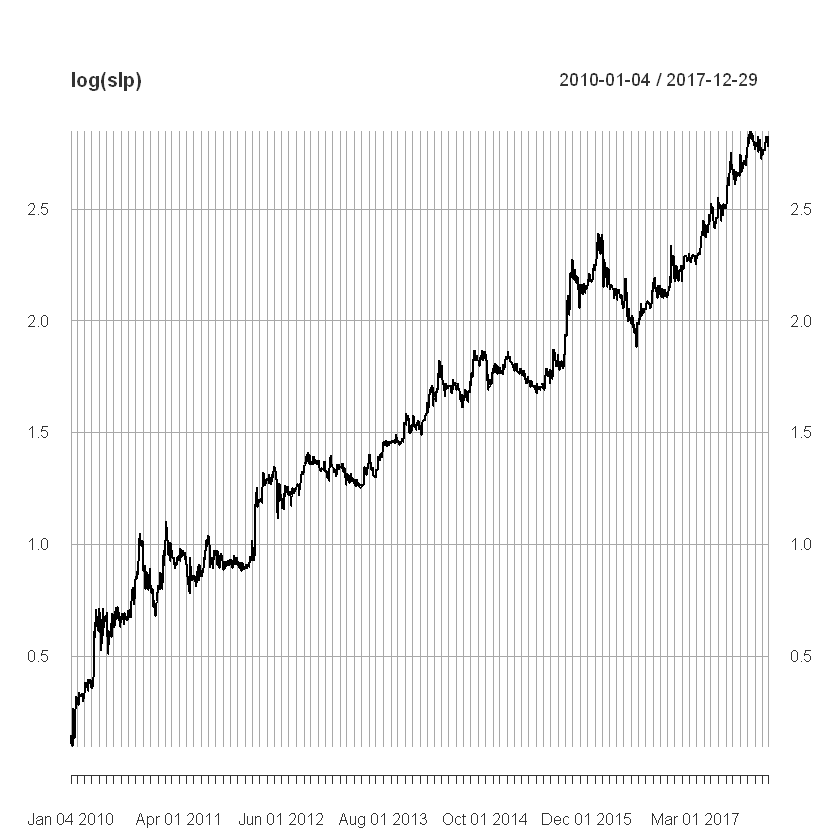

In [22]:
plot(log(slp))

We use a log scale since stock prices unusally increase in terms of proportions.

This is still non-stationary. We can try to remove the trend, but instead we're going to just use the different between success timesteps

In [25]:
kpss.test(log(slp)) # test for stationarity of log price
kpss.test(diff(log(slp))) # ... of log return


Warning message in kpss.test(log(slp)):
"p-value smaller than printed p-value"


	KPSS Test for Level Stationarity

data:  log(slp)
KPSS Level = 17.41, Truncation lag parameter = 10, p-value = 0.01


Warning message in kpss.test(diff(log(slp))):
"p-value greater than printed p-value"


	KPSS Test for Level Stationarity

data:  diff(log(slp))
KPSS Level = 0.066342, Truncation lag parameter = 10, p-value = 0.1


The KPSS test accepts the null hypothesis that the differences are stationary.

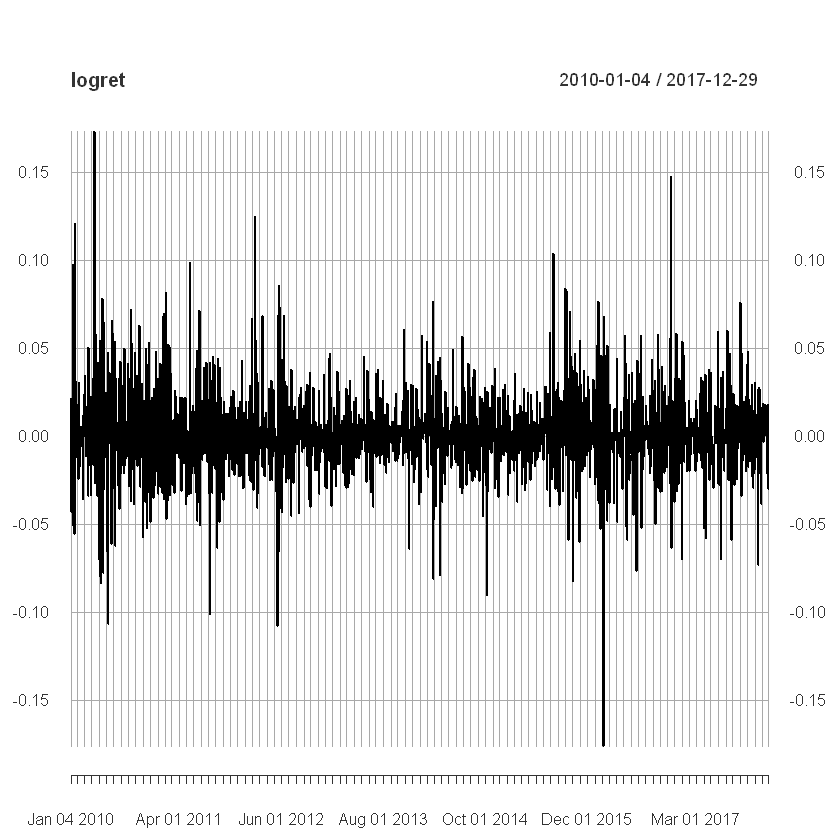

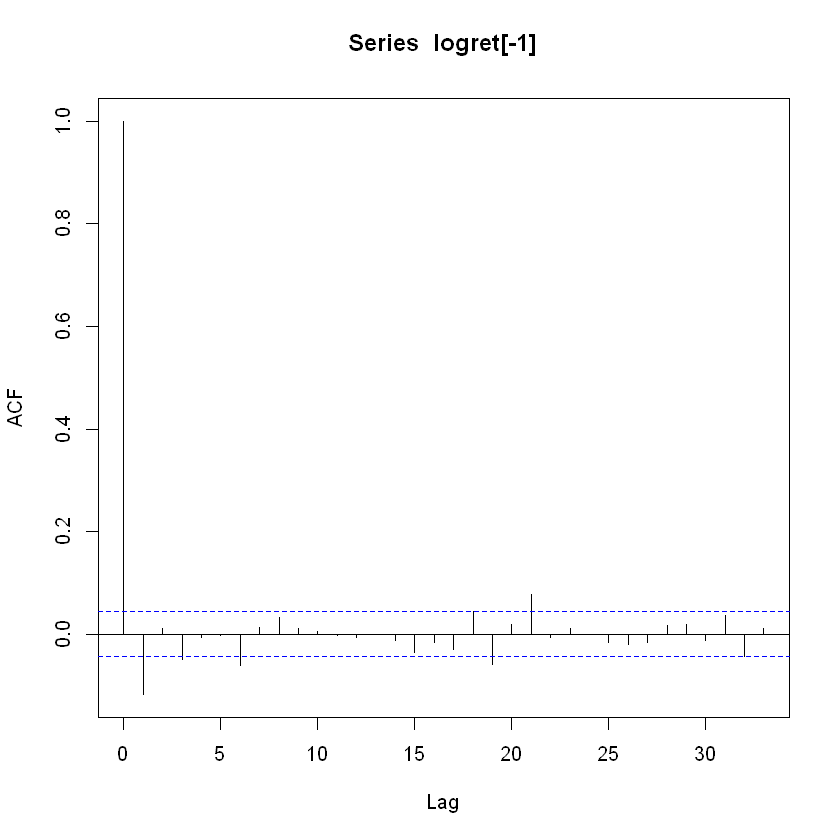

In [27]:
logret <- diff(log(slp))
plot(logret)
acf(logret[-1]) # log return undefined on day 1, so we remove it


Let's select a model automatically with the arima function

In [28]:
auto.arima(log(slp), ic='aic')

Series: log(slp) 
ARIMA(3,1,3) with drift 

Coefficients:
          ar1      ar2     ar3     ma1     ma2      ma3   drift
      -0.7714  -0.0924  0.5043  0.6588  0.0009  -0.5733  0.0013
s.e.   0.1713   0.2312  0.1453  0.1633  0.2103   0.1280  0.0004

sigma^2 estimated as 0.000573:  log likelihood=4658.03
AIC=-9300.06   AICc=-9299.99   BIC=-9255.21

We have fited a ARIMA(3,1,3) model with drift. We can try to backtest the model by testing the forecasting in one step with the historical data.

In [34]:
X <- as.numeric(logret[-1])
n <- length(slp)
pred <- pred_low <- pred_high <- rep(0,n)
test_start = 1763 # first day of 2017
for (t in test_start:n){
# we use Arima(), which is a wrapper of arima() but allows us to include drift
model <- Arima(X[1:(t-1)], order=c(3,1,3), include.drift=TRUE)
tmp <- forecast(model, 1, level=95)
pred[t] <- tmp$mean; pred_low[t] <- tmp$lower; pred_high[t] <- tmp$upper
printPercentage(t, n)

}

[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
89%[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
90%[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
91%[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
92%[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
93%[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
[1] "n"
94%[1] 


Call:
lm(formula = actual ~ pred, data = backtest)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.073321 -0.011258 -0.000939  0.010850  0.074211 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) 0.001911   0.001318   1.449   0.1485  
pred        0.961650   0.490025   1.962   0.0508 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02049 on 248 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.01529,	Adjusted R-squared:  0.01132 
F-statistic: 3.851 on 1 and 248 DF,  p-value: 0.05083


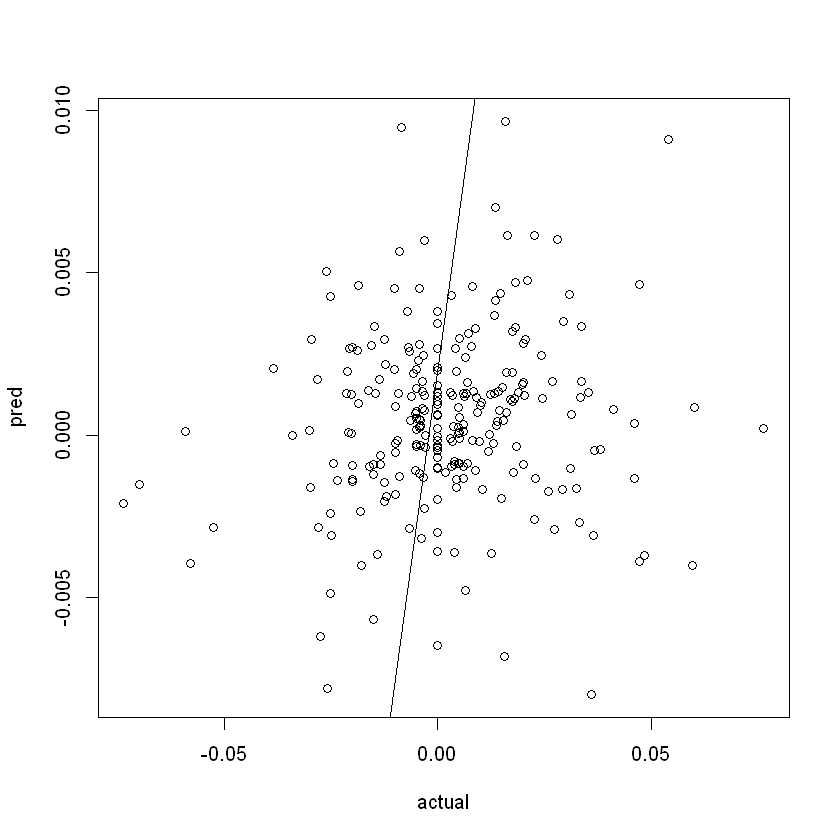

In [35]:
backtest <- data.frame(actual = X[test_start:n], pred = pred[test_start:n])
backtest.lm <- lm(actual~pred, data=backtest)
with(backtest, plot(actual, pred))
summary(backtest.lm)
abline(backtest.lm)

After all that is done... the plot is quite noisy, and the scatter plot shows little correlation between the predicted and actual data. The $\hat\sigma$ is actuall very large compared to the data. What little correlation is worthless because after model selection the errors are too optimistic.

This model won't make you much money.